In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import replace

import sys
import os
from tqdm import tqdm
import numpy as np

current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
if project_root not in sys.path:
    sys.path.append(project_root)

from minisearch.search import Searcher
from minisearch.quorum import QuorumConfig, QuorumCandidateGenerator
from minisearch.index import tokenize
from minisearch.query import parse_query, TermNode

In [3]:
def eval_cfg(index, queries_df, qrels, int_to_str_id, cfg: QuorumConfig):
    quorum = QuorumCandidateGenerator(index, tokenize_fn=tokenize, config=cfg)
    searcher = Searcher(index, None, quorum)

    hits = 0
    total = 0
    cand_sizes = []
    times_ms = []
    activated = 0

    for _, row in tqdm(queries_df.iterrows(), total=len(queries_df)):
        qid = int(row["query_id"])
        if qid not in qrels:
            continue

        text = row["text"]
        target_doc = next(iter(qrels[qid]))

        t0 = time.perf_counter()

        try:
            ast = parse_query(text)
        except Exception:
            ast = TermNode(text.lower())

        base = searcher._eval(ast)
        is_act = (searcher._is_simple_query(text) and len(base) < searcher.quorum.cfg.activate_if_candidates_lt)
        if is_act:
            base |= searcher.quorum.generate(text)

        dt = (time.perf_counter() - t0) * 1000.0

        activated += int(is_act)
        cand_sizes.append(len(base))
        times_ms.append(dt)

        cand_str = {int_to_str_id[i] for i in base}
        hits += int(target_doc in cand_str)
        total += 1

    cand_sizes = np.asarray(cand_sizes, dtype=np.int32)
    times_ms = np.asarray(times_ms, dtype=np.float32)

    return {
        "recall": float(hits / total) if total else 0.0,
        "hits": int(hits),
        "total": int(total),
        "activated_rate": float(activated / total) if total else 0.0,
        "cand_mean": float(cand_sizes.mean()) if len(cand_sizes) else 0.0,
        "cand_median": float(np.median(cand_sizes)) if len(cand_sizes) else 0.0,
        "cand_p95": float(np.percentile(cand_sizes, 95)) if len(cand_sizes) else 0.0,
        "ms_mean": float(times_ms.mean()) if len(times_ms) else 0.0,
        "ms_p95": float(np.percentile(times_ms, 95)) if len(times_ms) else 0.0,
    }


def sweep(base_cfg: QuorumConfig, name: str, param: str, values, index, queries_df, qrels, int_to_str_id):
    rows = []
    for v in values:
        cfg = replace(base_cfg, **{param: v})
        stats = eval_cfg(index, queries_df, qrels, int_to_str_id, cfg)
        rows.append({
            "sweep": name,
            "param": param,
            "value": v,
            **cfg.__dict__,
            **stats,
        })
    return pd.DataFrame(rows)


def plot_sweep(df, title):
    x = df["value"].to_numpy()
    param = df["param"].iloc[0]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    # 1) recall
    ax1.plot(x, df["recall"].to_numpy(), marker="o")
    ax1.set_title(title + " — recall")
    ax1.set_xlabel(param)
    ax1.set_ylabel("recall")
    ax1.grid(True)

    # 2) candidate pool size
    ax2.plot(x, df["cand_mean"].to_numpy(), marker="o", label="mean")
    ax2.plot(x, df["cand_median"].to_numpy(), marker="o", label="median")
    ax2.plot(x, df["cand_p95"].to_numpy(), marker="o", label="p95")
    ax2.set_title(title + " — candidate pool size")
    ax2.set_xlabel(param)
    ax2.set_ylabel("candidates")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()



In [4]:
base = QuorumConfig(
    activate_if_candidates_lt=1000,
    target=1000,
    cap=50000,
    anchor_pool=8,
    max_df_frac=0.20,
    k_frac=0.50,
    min_k=2,
    max_universe=200000
)

In [5]:
import aux

# build index
docs_df, queries_df, qrels = aux.load_data()
index, int_to_str_id = aux.build_index(docs_df)

Indexing...


100%|██████████| 101937/101937 [01:26<00:00, 1175.96it/s]


100%|██████████| 2000/2000 [01:07<00:00, 29.74it/s]


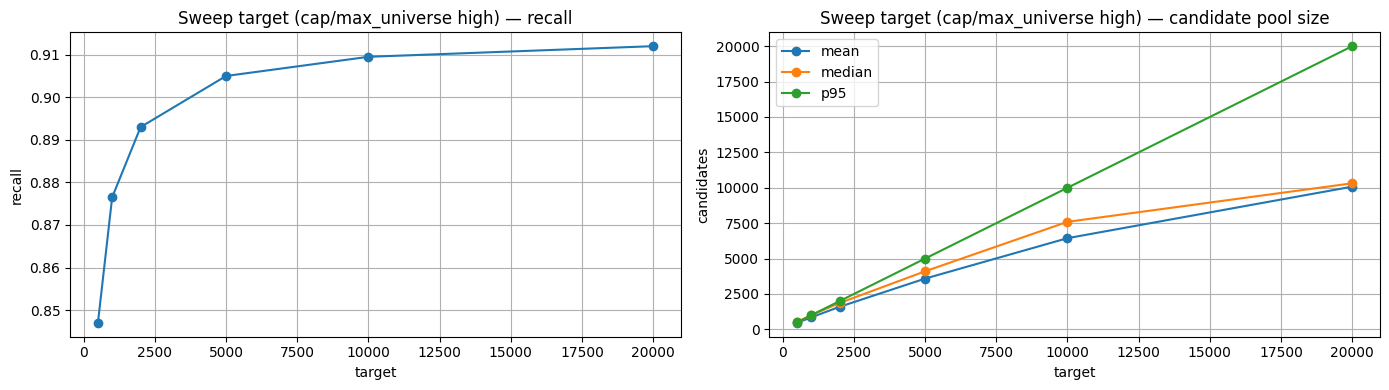

In [6]:
df_target = sweep(
    base, "target", "target",
    [500, 1000, 2000, 5000, 10000, 20000],
    index, queries_df, qrels, int_to_str_id
)
plot_sweep(df_target, "Sweep target (cap/max_universe high)")


100%|██████████| 2000/2000 [01:03<00:00, 31.70it/s]


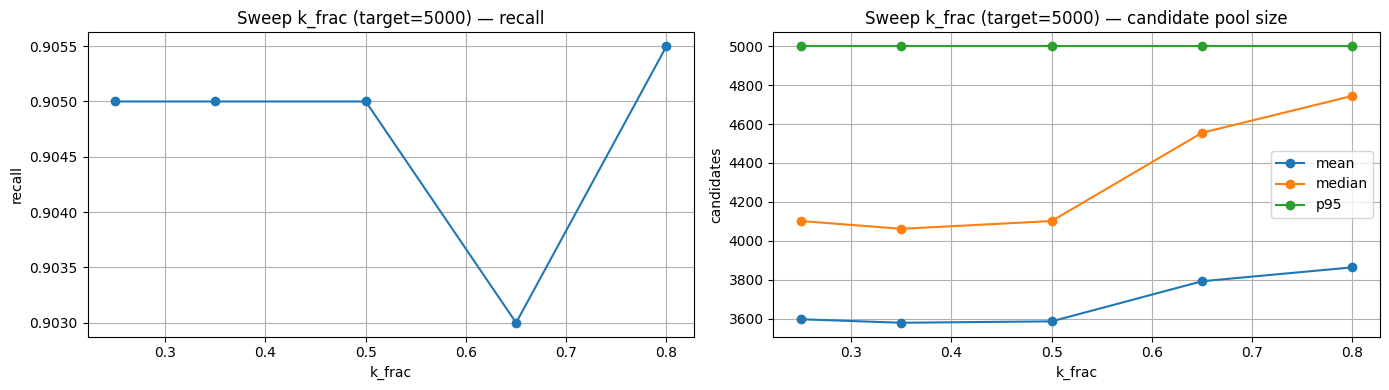

In [7]:
base_k = replace(base, target=5000)
df_kfrac = sweep(
    base_k, "k_frac", "k_frac",
    [0.25, 0.35, 0.50, 0.65, 0.80],
    index, queries_df, qrels, int_to_str_id
)
plot_sweep(df_kfrac, "Sweep k_frac (target=5000)")


100%|██████████| 2000/2000 [01:28<00:00, 22.59it/s]


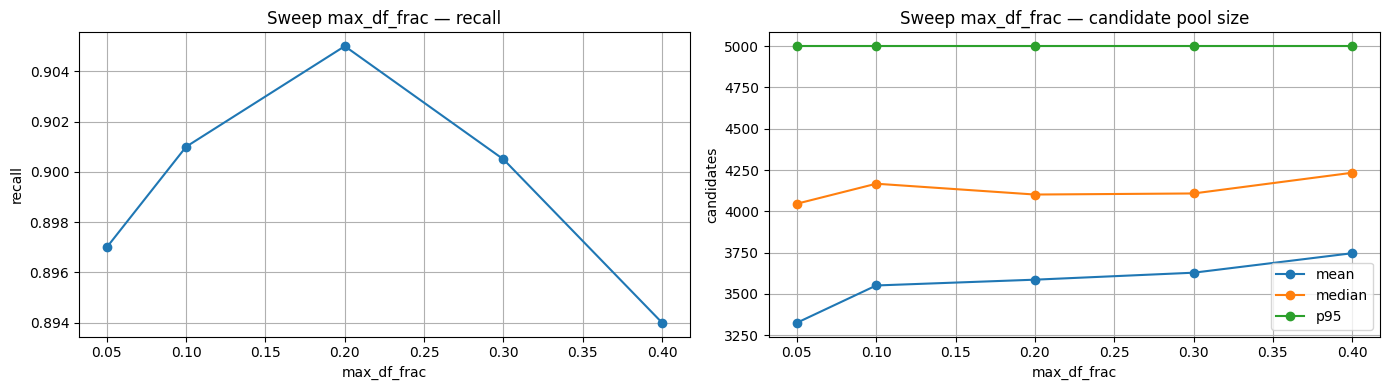

In [9]:
base_k = replace(base, target=5000)
df_maxdf = sweep(
    base_k, "max_df_frac", "max_df_frac",
    [0.05, 0.10, 0.20, 0.30, 0.40],
    index, queries_df, qrels, int_to_str_id
)
plot_sweep(df_maxdf, "Sweep max_df_frac")


100%|██████████| 2000/2000 [01:50<00:00, 18.06it/s]


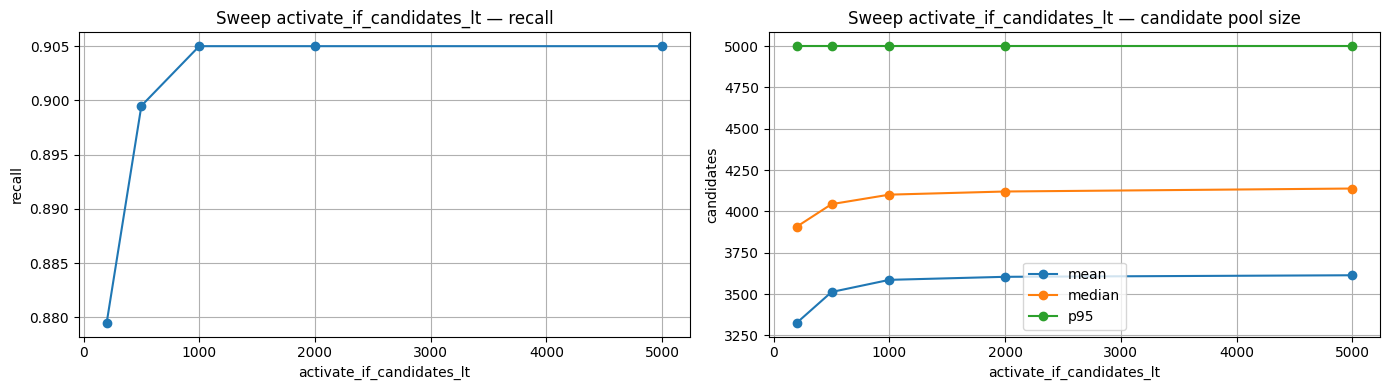

In [10]:
base_k = replace(base, target=5000)
df_activate = sweep(
    base_k, "activate_if_candidates_lt", "activate_if_candidates_lt",
    [200, 500, 1000, 2000, 5000],
    index, queries_df, qrels, int_to_str_id
)
plot_sweep(df_activate, "Sweep activate_if_candidates_lt")


**dummy quorum**

100%|██████████| 2000/2000 [00:55<00:00, 36.11it/s]


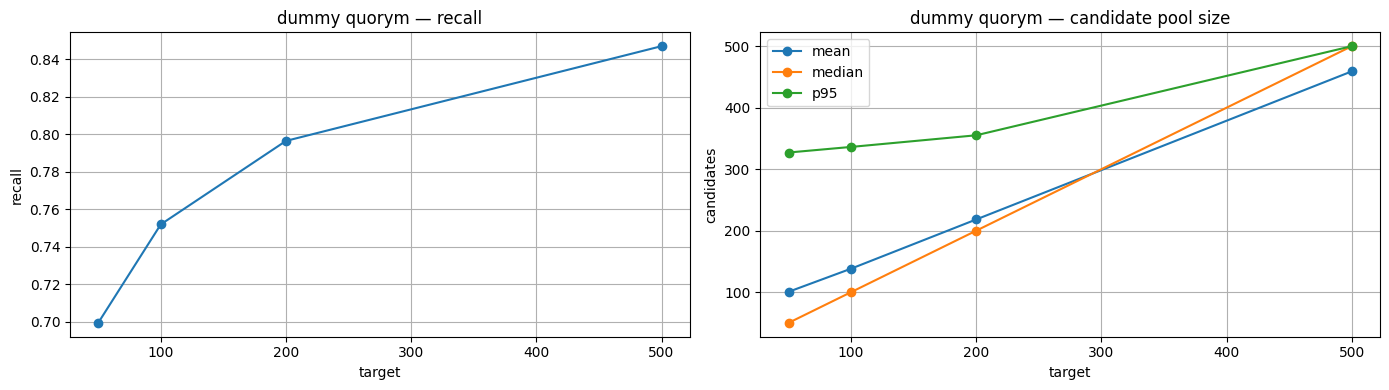

In [11]:
df_target = sweep(
    base, "target", "target",
    [50, 100, 200, 500],
    index, queries_df, qrels, int_to_str_id
)
plot_sweep(df_target, "dummy quorym")
